Sentiment Analysis with BERT

In [142]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [143]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [144]:
file_path = "final_dataset.csv"  # Remplacez par le chemin de votre fichier
df = pd.read_csv(file_path)

In [145]:
print(df.head())

    title  rating                                            content  \
0  Helix–       5  commande bien reçu merci pour votre profession...   
1  Helix–       4  Je suis très impressionnée par la qualité de c...   
2  Helix–       5  kthit menou lel khedma ihezli pc o les documen...   
3  Helix–       4  wselni le sac à dos je suis satisfait la quali...   
4  Helix–       5  Très pratique, surtout pour transporter mon or...   

                                     cleaned_content sentiment  
0  commande bien reçu merci pour votre profession...  positive  
1  je suis très impressionnée par la qualité de c...  positive  
2  kthit menou lel khedma ihezli pc le document f...  positive  
3  wselni le sac à do je suis satisfait la qualit...  positive  
4  très pratique surtout pour transporter mon ord...  positive  


In [146]:
#Keeping important columns from our dataset
test_data = df[['cleaned_content', 'sentiment']]
test_data.sample(5)

,cleaned_content,sentiment
628,le revêtement céramique pour voiture été une e...,negative
680,cest facile à assembler décemment robuste pour...,positive
1085,fonctionne très bien,positive
578,lowa barcha l brosse w lutilisation mteha sehl...,positive
1010,produit fonctionne bien,positive


In [147]:
from sklearn.model_selection import train_test_split
X = df['cleaned_content']
y = df['sentiment']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=2020)

Set up GPU for training

In [148]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: NVIDIA GeForce MX330


In [149]:
import nltk
from nltk.corpus import stopwords

def text_preprocessing(s):
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

TF-IDF Vectorizer

In [150]:
#%%time
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocess text
X_train_preprocessed = np.array([text_preprocessing(text) for text in X_train])
X_val_preprocessed = np.array([text_preprocessing(text) for text in X_val])

# Calculate TF-IDF
tf_idf = TfidfVectorizer(smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_val_tfidf = tf_idf.transform(X_val_preprocessed)

In [151]:
print("X_train_tfidf shape:", X_train_tfidf.shape)
print("y_train unique values:", np.unique(y_train))
print("y_train dtype:", y_train.dtype)


X_train_tfidf shape: (997, 3209)
y_train unique values: ['negative' 'neutral' 'positive']
y_train dtype: object


In [152]:
#because y_train is not numeric
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
print("Encoded labels:", np.unique(y_train))  # Should output [0, 1]


Encoded labels: [0 1 2]


In [153]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def get_auc_CV(model):
    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(5, shuffle=True, random_state=1)

    # Get AUC scores
    auc = cross_val_score(
        model, X_train_tfidf, y_train, scoring="roc_auc_ovr", cv=kf)

    return auc.mean()

Best alpha: 1.0


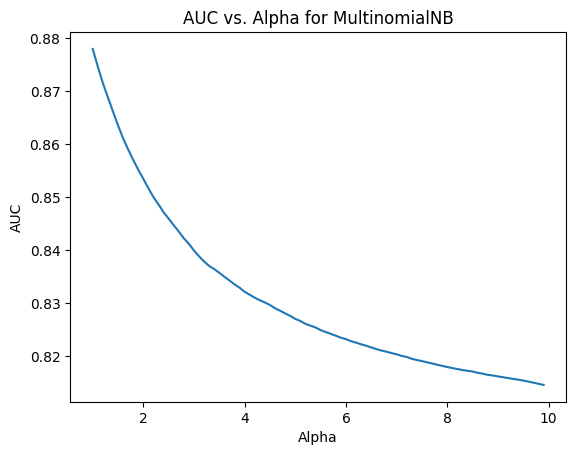

In [154]:
from sklearn.naive_bayes import MultinomialNB

res = pd.Series(
    [get_auc_CV(MultinomialNB(alpha=i)) for i in np.arange(1, 10, 0.1)], 
    index=np.arange(1, 10, 0.1)
)

best_alpha = np.round(res.idxmax(), 2)
print('Best alpha:', best_alpha)

plt.plot(res)
plt.title('AUC vs. Alpha for MultinomialNB')
plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.show()

The AUC score at 𝛼=1.0 (best alpha) is approximately 0.88, which is the highest performance observed in this experiment. This suggests that the model is well-calibrated with this smoothing parameter and achieves the best balance between overfitting and underfitting.

In [155]:
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.naive_bayes import MultinomialNB

def evaluate_roc(probs, y_true, num_classes=3):
    # Convert string labels to integer labels
    label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
    y_true_int = np.array([label_mapping[label] for label in y_true])

    # Binarize the true labels for multiclass (one-vs-rest approach)
    y_true_bin = label_binarize(y_true_int, classes=[0, 1, 2])  # Assuming 0 = negative, 1 = neutral, 2 = positive
    
    # Initialize the plot
    plt.figure()
    
    # Calculate ROC and AUC for each class
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], probs[:, i])
        roc_auc = auc(fpr, tpr)
        
        # Print AUC for each class
        print(f'Class {i} AUC: {roc_auc:.4f}')
        
        # Plot ROC curve for each class
        plt.plot(fpr, tpr, label=f'Class {i} AUC = {roc_auc:.2f}')
    
    # Get overall accuracy
    y_pred = np.argmax(probs, axis=1)
    accuracy = accuracy_score(y_true_int, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic for Multiclass')
    plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

NaN values in predicted probabilities: False
Zero columns in predicted probabilities: [False False False]
Class 0 AUC: 0.7546
Class 1 AUC: 1.0000
Class 2 AUC: 0.7981
Accuracy: 83.64%


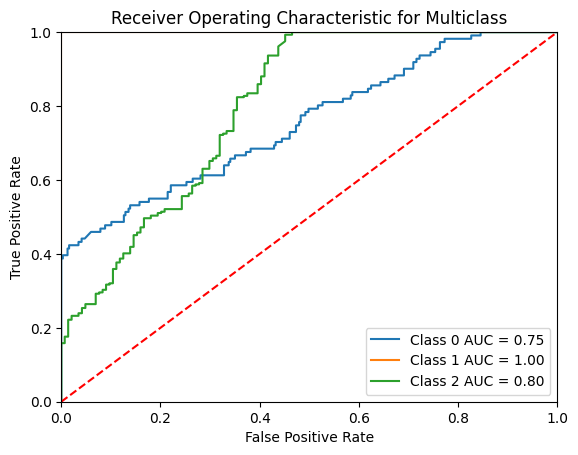

In [156]:
# Get the unique class labels
class_labels = np.unique(y_train)

# Compute predicted probabilities
nb_model = MultinomialNB(alpha=1.8)
nb_model.fit(X_train_tfidf, y_train)
probs = nb_model.predict_proba(X_val_tfidf)

# Check if the probs array has any NaN values or columns with all zeroes
print("NaN values in predicted probabilities:", np.isnan(probs).any())
print("Zero columns in predicted probabilities:", np.any(probs == 0, axis=0))

# Evaluate the classifier with the updated function
evaluate_roc(probs, y_val, num_classes=len(class_labels))

By combining TF-IDF and the Naive Bayes algorithm, we achieve the accuracy rate of 83.64% on the validation set. This value is the baseline performance and will be used to evaluate the performance of our fine-tune BERT model.

Fine-tuning BERT

In [157]:
!pip install transformers

In [158]:
def text_preprocessing(text):
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [159]:
# Print sentence 0
print('Original: ', X[0])
print('Processed: ', text_preprocessing(X[0]))

Original:  commande bien reçu merci pour votre professionnalisme comme décrit la qualité tayaraa
Processed:  commande bien reçu merci pour votre professionnalisme comme décrit la qualité tayaraa


In [160]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
MAX_LEN = 128

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [161]:
# Concatenate train data and test data
all_tweets = np.concatenate([X, y_val])

# Encode our concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  379


In [162]:
# Specify `MAX_LEN`
MAX_LEN = 379

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:  commande bien reçu merci pour votre professionnalisme comme décrit la qualité tayaraa
Token IDs:  [101, 3094, 2063, 29316, 28667, 2226, 21442, 6895, 10364, 29536, 7913, 9518, 12032, 2964, 2063, 4012, 4168, 11703, 14778, 2474, 24209, 11475, 2618, 28117, 5400, 2050, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

c:\Users\Admin\anaconda3\envs\Atelier_ML\lib\site-packages\transformers\tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [163]:
print(y_val[:10])
print(type(y_val))

1025    positive
1142    positive
228     positive
194     positive
965     positive
1050    positive
301     positive
1081    positive
321     positive
505     negative
Name: sentiment, dtype: object
<class 'pandas.core.series.Series'>


In [164]:
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Define label mapping
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}

# Convert string labels to numeric
if isinstance(y_train, pd.Series):
    y_train = y_train.map(label_mapping).values
if isinstance(y_val, pd.Series):
    y_val = y_val.map(label_mapping).values

# Ensure labels are NumPy arrays and cast to integers
train_labels = torch.tensor(y_train, dtype=torch.long)
val_labels = torch.tensor(y_val, dtype=torch.long)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 8

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

Train The Model

In [165]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.bert.gradient_checkpointing_enable()
        
        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)
        print("Logits shape:", logits.shape)
        print("Labels shape:", b_labels.shape)

        return logits

CPU times: total: 0 ns
Wall time: 0 ns


In [166]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

Training Loop

In [167]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

Training Our BertClassifier

In [168]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
